# SIMPLE KRIGING IN PYTHON

### Note:

*This Notebook is based on an original Post from Connor Johnson, the original post is found here:
http://connor-johnson.com/2014/03/20/simple-kriging-in-python/. It has been transferred to a Jupyter Notebook to make it more interactive, with only minor changes.*

*Changes being made:*
+ *using a common variogram function*
+ *calculation of variance map* 
+ *some code structure*

# Original Post

In this post I will work through an example of Simple Kriging. Kriging is a set of techniques for interpolation. It differs from other interpolation techniques in that it sacrifices smoothness for the integrity of sampled points. Most interpolation techniques will over or undershoot the value of the function at sampled locations, but kriging honors those measurements and keeps them fixed. In future posts I would like to cover other types of kriging, other semivariaogram models, and colocated co-kriging. Until then, I’m keeping relatively up to date code at my GitHub project, geostatsmodels. (https://github.com/cjohnson318/geostatsmodels)

## Data

The data used in this exercise is in a zip file at this site. (Click on Geostatistics Resources.) I have adapted my material from the Kriging document on the same site. My approach will focus more on programming. First we will import some modules and then load the data and parse it,

In [26]:
from pylab import *
import numpy as np
from pandas import DataFrame, Series
from scipy.spatial.distance import pdist, squareform
 
z = open( 'WGTutorial/ZoneA.dat','r' ).readlines()
z = [ i.strip().split() for i in z[10:] ]
z = np.array( z, dtype=np.float )
z = DataFrame( z, columns=['x','y','thk','por','perm','lperm','lpermp','lpermr'] )


Next, we will plot the data,

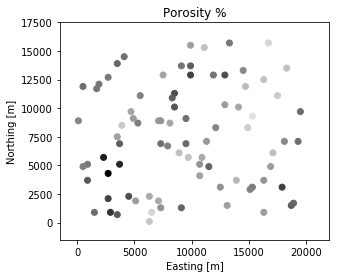

In [27]:
%matplotlib inline

fig, ax = subplots()
ax.scatter( z.x, z.y, c=z.por, cmap='gray' )
ax.set_aspect(1)
xlim(-1500,22000)
ylim(-1500,17500)
xlabel('Easting [m]')
ylabel('Northing [m]')
title('Porosity %') ;

In surveys, we generally specify one point in latitude and longitude, and then measure things as North and East of that point, hence the Northing and Easting.

## The Semivariogram

The semivariogram encodes data about spatial variance over the region at a given distance or lag. We generally expect data points that are close together spatially to share other characteristics, and we expect points that are separated by greater distances to have lesser correlation. The semivariogram allows us to model the similarity points in a field as a function of distance. The semivariogram is given by,

$$\begin{equation*} \hat{\gamma}(h) = \dfrac{1}{2N(h)} \displaystyle \sum_{N(h)} ( z_{i} - z_{j} )^{2} \end{equation*}$$ (Equation 1)

Here, h is distance specified by the user, and z_{i} and z_{j} are two points that are separated spatially by h. The N(h) term is the number of points we have that are separated by the distance h. The semivariogram then is the sum of squared differences between values separated by a distance h. As an aside, contrast this with the formulation for variance,

$$\begin{equation*} s = \dfrac{1}{N-1} \displaystyle \sum_{k=1}^{N} (z_{k} - \hat{\mu} )^{2} \end{equation*}$$ (Equation 2)

Here, $N$ is the number of data points, $\hat{\mu}$ is the sample mean, and $z_{k}$ is a data point. For sample variance, we are taking the squared difference between data points and the mean, and in the semivariogram we are taking the squared difference between data points separated by distance h. We can write some functions to calculate the semivariogram at one lag, and then at multiple lags as follows.

In [28]:
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    return np.sum( Z ) / ( 2.0 * len( Z ) )
 
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T
 
def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

The C() function is the covariance function, and will be used later. Let us now calculate and plot the semivariogram,

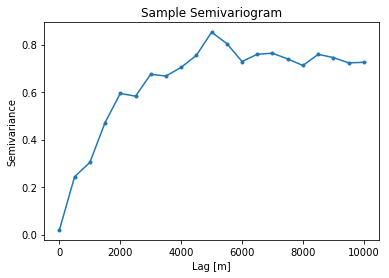

In [29]:
# part of our data set recording porosity
P = np.array( z[['x','y','por']] )
# bandwidth, plus or minus 250 meters
bw = 500
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0,10500,bw)
sv = SV( P, hs, bw )
plot( sv[0], sv[1], '.-' )
xlabel('Lag [m]')
ylabel('Semivariance')
title('Sample Semivariogram') ;
savefig('sample_semivariogram.png',fmt='png',dpi=200)


Modeling
Now that we’ve calculated the semivariogram, we will need to fit a model to the data. There are three popular models, the spherical, exponential, and the Gaussian. Here, we’ll implement the spherical model. First, we will present a function named opt() for determining the optimal value a for the spherical model.

In [30]:
def opt( fct, x, y, C0, parameterRange=None, meshSize=1000 ):
    if parameterRange == None:
        parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]

The opt() function finds the optimal parameter for fitting a spherical model to the semivariogram data. The spherical model is given by the function spherical(). On the last line we see that spherical() returns itself in a map() function, which seems odd. The idea is that the input h can be a single float value, or list or NumPy array of floats. If h is a single value, then line 9 is called. If h is a list or an array (an iterable) then line 17 is called, which applies line 9 to each value of h.

In [31]:
def spherical( h, a, C0 ):
    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

Next, cvmodel() fits a model to the semivariogram data and returns a covariance method named covfct().

In [32]:
def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponential
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a=param: C0 - model( h, a, C0 )
    return covfct

At this point we’ll plot our model and see if it represents our data well.

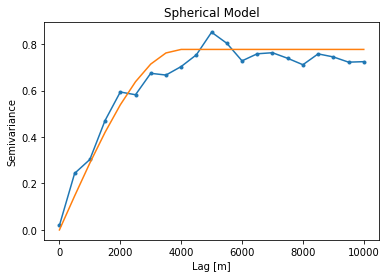

In [33]:
sp = cvmodel( P, model=spherical, hs=np.arange(0,10500,500), bw=500 )
C0 = C( P, hs[0], bw )
plot( sv[0], sv[1], '.-' )
plot( sv[0], C0 - sp( sv[0] ) ) ;
title('Spherical Model')
ylabel('Semivariance')
xlabel('Lag [m]')
savefig('semivariogram_model.png',fmt='png',dpi=200)


## Simple Kriging


Now that we have a model for the semivariogram, we can write a function to perform the kriging. The fundamental relationship is a matrix equation,

$$\begin{equation*} K \lambda = k \Rightarrow \lambda = K^{-1} k \end{equation*} $$ 

Here, $K$ is a matrix of covariances calculated using the spherical model, $\lambda$ is a vector of simple kriging weights, and $k$ is the vector of covariances between the data points and an unsampled point. Our kriging function takes the data set $P$, the model, the distances hs, the bandwidth bw, the coordinates of the unsampled point u, and the number of surrounding points N to use in the calculation.

In [34]:
def krige( P, covfct, u, N ):
    '''
    Input  (P)     ndarray, data
           (model) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (hs)    kriging distances
           (bw)    kriging bandwidth
           (u)     unsampled point
           (N)     number of neighboring
                   points to consider
    '''
 
    # mean of the variable
    mu = np.mean( P[:,2] )
 
    # distance between u and each data point in P
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 )
    # add these distances to P
    P = np.vstack(( P.T, d )).T
    # sort P by these distances
    # take the first N of them
    P = P[d.argsort()[:N]]
 
    # apply the covariance model to the distances
    k = covfct( P[:,3] )
    # cast as a matrix
    k = np.matrix( k ).T
 
    # form a matrix of distances between existing data points
    K = squareform( pdist( P[:,:2] ) )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )
 
    # calculate the kriging weights
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights )
 
    # calculate the residuals
    residuals = P[:,2] - mu
 
    # calculate the estimation
    estimation = np.dot( weights.T, residuals ) + mu
 
    return (float( estimation ), k, K, weights)

## Calculation

Here, we’ll calculate the kriging estimate at a number of unsampled points.

In [35]:
X0, X1 = P[:,0].min(), P[:,0].max()
Y0, Y1 = P[:,1].min(), P[:,1].max()
Z = np.zeros((80,100))
V = np.zeros((80,100))
dx, dy = (X1-X0)/100.0, (Y1-Y0)/80.0
for i in range( 80 ):
    print i,
    for j in range( 100 ):
        h, k, K, weights = krige( P, sp, (dx*j,dy*i), 16 )
        Z[i,j] = h
        V[i,j] = C0 - np.dot(k.T, weights)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79


## Plotting the Estimator

We’ll try to reproduce one of the graphs found on the site with the data. I kind of guessed on the colormap.

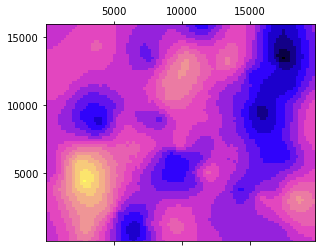

In [36]:
cdict = {'red':   ((0.0, 1.0, 1.0),
                   (0.5, 225/255., 225/255. ),
                   (0.75, 0.141, 0.141 ),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 1.0, 1.0),
                   (0.5, 57/255., 57/255. ),
                   (0.75, 0.0, 0.0 ),
                   (1.0, 0.0, 0.0)),
         'blue':  ((0.0, 0.376, 0.376),
                   (0.5, 198/255., 198/255. ),
                   (0.75, 1.0, 1.0 ),
                   (1.0, 0.0, 0.0)) }
 
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
 
fig, ax = subplots()
H = np.zeros_like( Z )
for i in range( Z.shape[0] ):
    for j in range( Z.shape[1] ):
        H[i,j] = np.round( Z[i,j]*3 )
 
ax.matshow( H, cmap=my_cmap, interpolation='nearest' )
ax.scatter( z.x/200.0, z.y/200.0, facecolor='none', linewidths=0.75, s=50 )
xlim(0,99) ; ylim(0,80)
xticks( [25,50,75], [5000,10000,15000] )
yticks( [25,50,75], [5000,10000,15000] )
savefig( 'krigingpurple.png', fmt='png', dpi=200 )


## Plotting the Variance

We'll also plot the variance to show the uncertainties

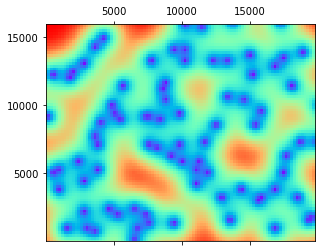

In [37]:
cdict = {'red':   ((0.0, 1.0, 1.0),
                   (0.5, 225/255., 225/255. ),
                   (0.75, 0.141, 0.141 ),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 1.0, 1.0),
                   (0.5, 57/255., 57/255. ),
                   (0.75, 0.0, 0.0 ),
                   (1.0, 0.0, 0.0)),
         'blue':  ((0.0, 0.376, 0.376),
                   (0.5, 198/255., 198/255. ),
                   (0.75, 1.0, 1.0 ),
                   (1.0, 0.0, 0.0)) }
 
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
 
fig, ax = subplots()
H = np.zeros_like( V )
for i in range( V.shape[0] ):
    for j in range( V.shape[1] ):
        H[i,j] = np.round( V[i,j]*3 )
 
ax.matshow( V, cmap="rainbow", interpolation='nearest' )
ax.scatter( z.x/200.0, z.y/200.0, facecolor='none', linewidths=0.75, s=50 )
xlim(0,99) ; ylim(0,80)
xticks( [25,50,75], [5000,10000,15000] )
yticks( [25,50,75], [5000,10000,15000] )
 
savefig( 'krigingpurple.png', fmt='png', dpi=200 )